In [ ]:
import pandas as pd
from transformers import pipeline

file_path = "classified_test_data.csv"
data = pd.read_csv(file_path)
data['text'] = ' '

df3 = pd.read_csv("/content/test_data_123.csv")
for idx, paper_id in enumerate(data['Paper ID']):
    for i in range(len(df3)):
        if paper_id == df3['Paper ID'][i]:
            data.loc[data['Paper ID'] == paper_id, 'text'] = df3['text'][i]
            break


def preprocess_text(text, max_tokens=512):
    if not isinstance(text, str) or not text.strip():
        return "Text missing or invalid."
    tokens = text.split()
    if len(tokens) > max_tokens:
        return ' '.join(tokens[:max_tokens])
    return text


print("Loading the FLAN-T5 model...")
llm_pipeline = pipeline("text2text-generation", model="google/flan-t5-small", device=-1)


def llm_generate_rationale(text, predicted_conference):
    try:
        clean_input = preprocess_text(text)
        if clean_input == "Text missing or invalid.":
            return clean_input

        conference_info = {
            """KDD (Knowledge Discovery and Data Mining)*:
SIGKDD imposes a high requirement to present and publish submitted papers. The focus is on innovative research in data mining, knowledge discovery, and large-scale data analytics. Papers emphasizing theoretical foundations are particularly encouraged, as are novel modeling and algorithmic approaches to specific data mining problems in scientific, business, medical, and engineering applications. Visionary papers on new and emerging topics are particularly welcomed. Authors are explicitly discouraged from submitting papers that contain only incremental results or that do not provide significant advances over existing approaches.

NeurIPS (Neural Information Processing Systems):
Along with machine learning and neuroscience, other fields represented at NeurIPS include cognitive science, psychology, computer vision, statistical linguistics, and information theory. Over the years, NeurIPS has become a premier conference on machine learning. It focuses on novel theoretical advancements and empirical validations in fields such as neural networks, reinforcement learning, and deep learning, particularly in areas such as speech recognition, object recognition in images, and language translation.

CVPR (Computer Vision and Pattern Recognition):
CVPR covers a wide range of topics related to computer vision and pattern recognition. This includes any topic related to extracting structures or answers from images or video or applying mathematical methods to data to extract or recognize patterns. Common topics include object recognition, image segmentation, motion estimation, 3D reconstruction, and deep learning.

EMNLP (Empirical Methods in Natural Language Processing):
EMNLP is a leading conference in the area of natural language processing (NLP). It is one of the three primary high-impact conferences for NLP research, along with ACL and NAACL. The conference focuses on empirical methods in NLP and artificial intelligence, highlighting research that deals with machine learning, linguistics, and computational models for understanding and generating human language.

TMLR (Transactions on Machine Learning Research):
TMLR is a new venue for the dissemination of machine learning research, which emphasizes technical correctness over subjective significance. It supports research that may not yet be accepted in mainstream venues but is important for the future of ML. TMLR is focused on shorter format manuscripts, fast reviews, and flexible timelines, which enables rapid scientific discourse on new and important topics in ML
        """}

        prompt = (
            f"Abstract: {clean_input}\n\n"
            f"Conference: {predicted_conference}\n"
            f"{conference_info.get(predicted_conference, '')}\n"
            f"Explain in 50-90 words why this paper aligns with the themes, focus areas, and standards of {predicted_conference}."
        )
        generated = llm_pipeline(prompt, max_new_tokens=90, num_return_sequences=1)[0]['generated_text']
        return generated.strip()
    except Exception as e:
        print(f"Error generating rationale: {e}")
        return "Rationale generation failed."

print("Generating rationales...")
for idx, row in data.iterrows():
    try:
        rationale = llm_generate_rationale(row['text'], row['Conference'])
        data.at[idx, 'Rationale'] = rationale
        print(f"Paper ID {row['Paper ID']} rationale:\n{rationale}\n")  # Print rationale for each paper
        if idx % 10 == 0:
            print(f"Processed {idx + 1}/{len(data)} papers.")
    except Exception as e:
        print(f"Failed for Paper ID {row['Paper ID']}: {e}")
        data.at[idx, 'Rationale'] = "Failed to generate rationale."

output_path = "results.csv"
data.to_csv(output_path, index=False)
print(f"Rationale-enhanced dataset saved to {output_path}")

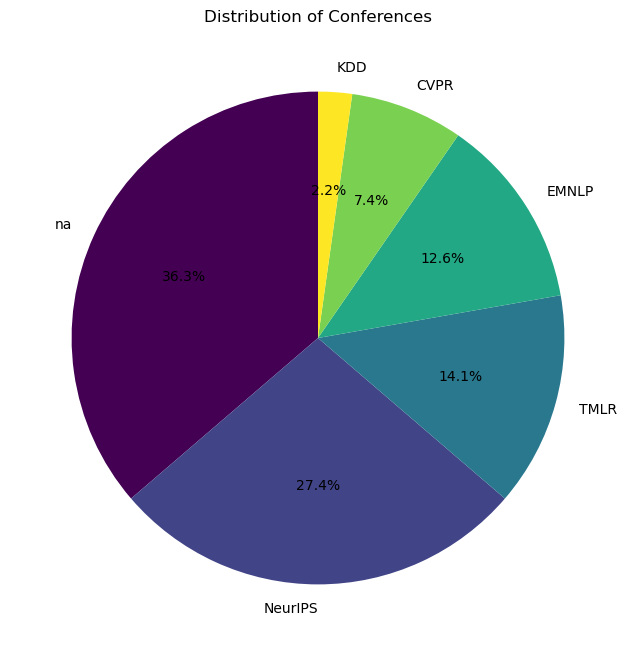

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

conference_counts = data['Conference'].value_counts()

plt.figure(figsize=(8, 8))
conference_counts.plot.pie(autopct='%1.1f%%', startangle=90, cmap='viridis')
plt.title('Distribution of Conferences')
plt.ylabel('')
plt.show()